In [ ]:
# Library imports
%matplotlib inline
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pennylane as qml

# Pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
device = torch.device('cpu')

In [ ]:
#Prep Training Data (Breast Cancer Wisconsin)

#Load the data file
df = pd.read_csv("data/wdbc.data", header=None)


#Assign column names
columns = ['id', 'diagnosis'] + [f'feature_{i}' for i in range(1, 31)]
df.columns = columns
print(df.head)
#Drop the ID column
df = df.drop(columns=['id'])

#Encode diagnosis: M = 1, B = 0
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

#Convert to numpy arrays
X = df.drop(columns=['diagnosis']).values.astype(np.float32)
Y = df['diagnosis'].values.astype(np.float32).reshape(-1, 1)

#Normalize features manually (z-score)
mean = X.mean(axis=0)
std = X.std(axis=0)
X = (X - mean) / std

#Convert to torch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

#Manual train/test split (80/20)
num_samples = X_tensor.shape[0]
indices = torch.randperm(num_samples)

split_idx = int(num_samples * 0.8)
train_indices = indices[:split_idx]
test_indices = indices[split_idx:]
X_train = X_tensor[train_indices]
Y_train = Y_tensor[train_indices]
X_test = X_tensor[test_indices]
Y_test = Y_tensor[test_indices]
print(X.shape, Y.shape)
                


<bound method NDFrame.head of            id diagnosis  feature_1  feature_2  feature_3  feature_4  \
0      842302         M      17.99      10.38     122.80     1001.0   
1      842517         M      20.57      17.77     132.90     1326.0   
2    84300903         M      19.69      21.25     130.00     1203.0   
3    84348301         M      11.42      20.38      77.58      386.1   
4    84358402         M      20.29      14.34     135.10     1297.0   
..        ...       ...        ...        ...        ...        ...   
564    926424         M      21.56      22.39     142.00     1479.0   
565    926682         M      20.13      28.25     131.20     1261.0   
566    926954         M      16.60      28.08     108.30      858.1   
567    927241         M      20.60      29.33     140.10     1265.0   
568     92751         B       7.76      24.54      47.92      181.0   

     feature_5  feature_6  feature_7  feature_8  ...  feature_21  feature_22  \
0      0.11840    0.27760    0.30010 

The base idea for this model is a quanvolutional neural network that uses multiple quantum kernels for quantum feature extraction. Here I use 3 1D filter kernels of size 3, allowing us to map a 30 feature datapoint to a (9,10) dimension tensor. The output of this is passed into a classical convolutional layer. One can use a quantum convolutional neural network instead, but due to time and resource constraints, I opted for a classical CNN.

In [4]:

quanv_dev1 = qml.device('lightning.qubit', wires = 3)
@qml.qnode(quanv_dev1, interface='torch', diff_method = 'best')
def quanv_circ1(input_vals, params):
    qml.IQPEmbedding(input_vals.detach(), list(range(len(input_vals))))
    for j in range(3):
        qml.U3(params[3*j], 
                params[3*j + 1], 
                params[3*j + 2],
                wires = j)
    qml.CNOT(wires = [1,2])
    qml.IsingXX(params[3*3], wires = [0,1])
    qml.IsingYY(params[3*3 + 1], wires = [0,1])
    qml.IsingZZ(params[3*3 + 2], wires = [0,1])
    qml.CNOT(wires = [1,2])
    for j in range(3):
        qml.U3(params[3*j + 12], 
                params[3*j + 1 + 12], 
                params[3*j + 2 + 12],
                wires = j)
    
    return [qml.expval(qml.PauliZ(i)) for i in [0,1,2]]

quanv_dev2 = qml.device('lightning.qubit', wires = 3)
@qml.qnode(quanv_dev2, interface='torch', diff_method = 'best')
def quanv_circ2(input_vals, params):
    qml.IQPEmbedding(input_vals, list(range(len(input_vals))))
    for j in range(3):
        qml.U3(params[3*j],
                params[3*j+1],
                params[3*j+2],
                wires = j)
        qml.CNOT(wires = [j,(j+1)%3])
    qml.MultiRZ(params[3*3], wires = [0,1,2])

    return [qml.expval(qml.PauliZ(i)) for i in [0,1,2]]


quanv_dev3 = qml.device('lightning.qubit', wires = 3)
@qml.qnode(quanv_dev3, interface='torch', diff_method = 'best')
def quanv_circ3(input_vals, params):
    qml.IQPEmbedding(input_vals, list(range(len(input_vals))))
    for j in range(3):
        qml.Rot(params[3*j],
                params[3*j+1],
                params[3*j+2],
                wires = j)
    qml.ctrl(qml.U3(params[3*3], 
            params[1 + 3*3], 
            params[2 + 3*3],
            wires = 1), control = 0, control_values = 1)
    qml.ctrl(qml.U3(params[4*3], 
            params[1 + 4*3], 
            params[2 + 4*3],
            wires = 2), control = 0, control_values = 1)
    return [qml.expval(qml.PauliZ(i)) for i in [0,1,2]]   

def quanv(data, stride, params, num_qubits):
    num_qubits = 3
    dim = data.size(1)
    out_cols = (dim // stride) // 3
    out = torch.zeros((3 * num_qubits, out_cols))
    for idx, start in enumerate(range(0, dim - 3*stride + 1, 3*stride)):
        seg1 = data[0, start:start+stride]
        seg2 = data[0, start+stride:start+2*stride]
        seg3 = data[0, start+2*stride: start+3*stride]
        q1 = quanv_circ1(seg1, params[:21])
        q2 = quanv_circ2(seg2, params[21:31])
        q3 = quanv_circ3(seg3, params[31:])
        for i in range(num_qubits):
            out[3*i,   idx] = q1[i]
            out[3*i+1, idx] = q2[i]
            out[3*i+2, idx] = q3[i]
    return out


Here, you can see the architecture of the model, including the classical layers.

In [5]:
class HybridModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.q_params = nn.ParameterList(
            [
                nn.Parameter(torch.randn((46))*np.pi, requires_grad=True)
            ]
        )
        self.classical = nn.Sequential(
            nn.Conv1d(in_channels=9, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(in_channels = 16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.output = nn.Sequential(
            nn.Linear(2*32, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        quanv_output = None
        for q_param in self.q_params:
            quanv_output = quanv(x, 1, q_param, 3).view(1,9,10)
        convolution_output = self.classical(quanv_output).view(1, 32*2)
        output = self.output(convolution_output)
        return output


Methods to evaluate robustness

In [11]:
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score

def fgsm_attack(model, x, y, epsilon, device):
    x_adv = x.clone().detach().to(device).requires_grad_(True)
    out = model(x_adv)


    loss = F.binary_cross_entropy_with_logits(out, y.float().to(device))
    model.zero_grad()
    loss.backward()
    
    x_adv = x_adv + epsilon * x_adv.grad.sign()
    return x_adv.detach()

def evaluate_robustness(model, device, X_test, Y_test, epsilons=[0.0,0.01,0.05,0.1]):
    model.eval()
    results = {}
    ds = TensorDataset(X_test, Y_test.view(-1))
    loader = DataLoader(ds, batch_size=1, shuffle=False)
    
    for eps in epsilons:
        preds = []
        trues = []
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            
            if eps == 0.0:
                x_adv = x
            else:
                x_adv = fgsm_attack(model, x, y, eps, device)
            
            with torch.no_grad():
                out = model(x_adv)
                if out.dim()==2 and out.size(1)==1:
                    out = out.view(-1)
                prob = out   # [1]
                pred = (prob >= 0.5).long().item()
            
            preds.append(pred)
            trues.append(y.item())
        
        results[eps] = accuracy_score(trues, preds)
    return results


Training loop. I used a regularization loss term since I was finding that this model fits easily to the training dataset. Compared to a simple classical CNN classifier, unfortunately we acquire lower test accuracy, F-1 score, precision, and recall. Nonetheless, I thought this model performed quite well on this particular dataset, where it appeared difficult to acquire any comparable performance to a classical classifier.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

# — configs — 
device       = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
k_folds      = 5
n_epochs     = 25
batch_size   = 1
lr           = 0.0002
betas        = (0.5, 0.999)
weight_decay = 0.005

X_tr = X_train.cpu()  
Y_tr = Y_train.view(-1).cpu().long()
X_te = X_test.to(device)
Y_te = Y_test.view(-1).to(device).long()

ensemble_models = []

# Stratify only on the training set
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
for fold, (train_idx, _) in enumerate(skf.split(X_tr, Y_tr), 1):
    print(f"\n→ Fold {fold}/{k_folds}")

    # Build fold‐specific loader
    X_fold = X_tr[train_idx].to(device)
    Y_fold = Y_tr[train_idx].to(device)
    train_loader = DataLoader(
        TensorDataset(X_fold, Y_fold),
        batch_size=batch_size,
        shuffle=True
    )
    # Compute pos_weight = (#neg / #pos) on this fold
    n_pos = int((Y_fold==1).sum().item())
    n_neg = int((Y_fold==0).sum().item())
    pos_weight = n_neg / n_pos
    print(f"  pos/neg = {n_pos}/{n_neg} → pos_weight = {pos_weight:.2f}")

    model_f = HybridModel().to(device)
    optimizer_f = torch.optim.Adam(
        model_f.parameters(),
        lr=lr, betas=betas, weight_decay=weight_decay
    )
    for epoch in range(1, n_epochs+1):
        model_f.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            optimizer_f.zero_grad()
            pred = model_f(xb).view(-1)
            weights = torch.where(
                yb==1,
                torch.tensor(pos_weight, device=device),
                torch.tensor(1.0,        device=device)
            )
            loss = F.binary_cross_entropy(pred, yb.float(), weight=weights)
            loss.backward()
            optimizer_f.step()
            running_loss += loss.item() * xb.size(0)
        print(f"    Epoch {epoch:02d} — loss {running_loss/len(train_loader.dataset):.4f}")

    model_f.eval()
    ensemble_models.append(model_f)


all_probs = []
with torch.no_grad():
    for m in ensemble_models:
        probs = []
        for x in X_te:
            p = m(x.unsqueeze(0)).view(-1)[0].item()
            probs.append(p)
        all_probs.append(probs)

avg_probs  = np.mean(np.vstack(all_probs), axis=0)
y_pred_ens = (avg_probs >= 0.5).astype(int)
y_true_te  = Y_te.cpu().numpy()

print("Ensemble Test Accuracy:  ", accuracy_score(y_true_te, y_pred_ens))
print("Ensemble Test Precision: ", precision_score(y_true_te, y_pred_ens))
print("Ensemble Test Recall:    ", recall_score(y_true_te, y_pred_ens))
print("Ensemble Test F1-score:  ", f1_score(y_true_te, y_pred_ens))



→ Fold 1/5
  pos/neg = 132/232 → pos_weight = 1.76
    Epoch 01 — loss 0.7409
    Epoch 02 — loss 0.4992
    Epoch 03 — loss 0.3606
    Epoch 04 — loss 0.2987
    Epoch 05 — loss 0.2464
    Epoch 06 — loss 0.2036
    Epoch 07 — loss 0.1836
    Epoch 08 — loss 0.1547
    Epoch 09 — loss 0.1389
    Epoch 10 — loss 0.1364
    Epoch 11 — loss 0.1026
    Epoch 12 — loss 0.0930
    Epoch 13 — loss 0.0830
    Epoch 14 — loss 0.0639
    Epoch 15 — loss 0.0676
    Epoch 16 — loss 0.0465
    Epoch 17 — loss 0.0419
    Epoch 18 — loss 0.0299
    Epoch 19 — loss 0.0271
    Epoch 20 — loss 0.0319
    Epoch 21 — loss 0.0231
    Epoch 22 — loss 0.0220
    Epoch 23 — loss 0.0134
    Epoch 24 — loss 0.0126
    Epoch 25 — loss 0.0133

→ Fold 2/5
  pos/neg = 133/231 → pos_weight = 1.74
    Epoch 01 — loss 0.8055
    Epoch 02 — loss 0.5749
    Epoch 03 — loss 0.3834
    Epoch 04 — loss 0.2657
    Epoch 05 — loss 0.2251
    Epoch 06 — loss 0.1759
    Epoch 07 — loss 0.1490
    Epoch 08 — loss 0.1094
    E

In [8]:
print("Ensemble Test Accuracy:  ", accuracy_score(y_true_te, y_pred_ens)*100)
print("Ensemble Test Precision: ", precision_score(y_true_te, y_pred_ens))
print("Ensemble Test Recall:    ", recall_score(y_true_te, y_pred_ens))
print("Ensemble Test F1-score:  ", f1_score(y_true_te, y_pred_ens))

Ensemble Test Accuracy:   94.73684210526315
Ensemble Test Precision:  0.9761904761904762
Ensemble Test Recall:     0.8913043478260869
Ensemble Test F1-score:   0.9318181818181818


In [17]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score

def evaluate_ensemble_robustness(ensemble_models, device, X_test, Y_test, epsilons):
    """
    Evaluate ensemble accuracy under FGSM attack for various epsilons.
    For each epsilon:
      - For each model in the ensemble:
          • Generate adversarial examples on X_test (per-sample FGSM).
          • Collect model probabilities on those adversarial inputs.
      - Average probabilities across models.
      - Threshold at 0.5 and compute accuracy.
    Returns a dict mapping epsilon -> ensemble accuracy.
    """
    ensemble_robustness = {}

    for eps in epsilons:
        # Collect per-model probability lists
        per_model_probs = []

        for model in ensemble_models:
            model.eval()
            probs = []
            for i in range(X_test.size(0)):
                x = X_test[i].unsqueeze(0).to(device)
                y = Y_test[i].unsqueeze(0).long().to(device)
                # generate adversarial or keep clean
                if eps > 0.0:
                    x_adv = fgsm_attack(model, x, y, eps, device)
                else:
                    x_adv = x
                with torch.no_grad():
                    p = model(x_adv).view(-1)[0].item()  # assumes sigmoid final
                probs.append(p)
            per_model_probs.append(probs)

        # average probabilities across models: shape = [n_test]
        avg_probs = np.mean(np.array(per_model_probs), axis=0)
        y_pred = (avg_probs >= 0.5).astype(int)
        y_true = Y_test.view(-1).cpu().numpy().astype(int)

        acc = accuracy_score(y_true, y_pred)
        ensemble_robustness[eps] = acc

    return ensemble_robustness

# — USAGE —
epsilons = [0.0, 0.01, 0.05, 0.1, 0.2]
ensemble_robustness = evaluate_ensemble_robustness(
    ensemble_models, device, X_test, Y_test, epsilons
)
print("Ensemble Accuracy vs ε:", ensemble_robustness)


Ensemble Accuracy vs ε: {0.0: 0.9473684210526315, 0.01: 0.9473684210526315, 0.05: 0.8859649122807017, 0.1: 0.8333333333333334, 0.2: 0.6666666666666666}


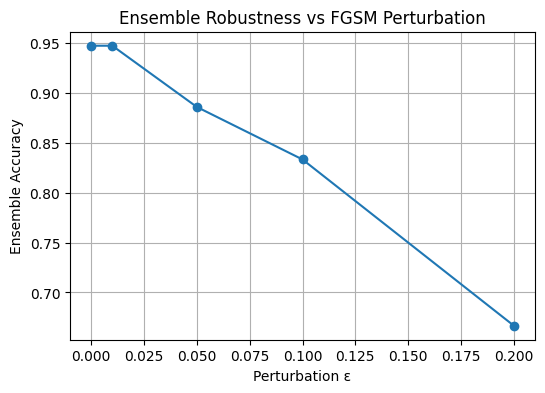

In [18]:
epsilons  = sorted(ensemble_robustness.keys())                 # [0.0, 0.01, 0.05, 0.1]
accuracies = [ensemble_robustness[e] for e in epsilons]        # [0.95, 0.90, 0.75, 0.60]

# 3. Plot
plt.figure(figsize=(6,4))
plt.plot(epsilons, accuracies, marker='o', linestyle='-')
plt.xlabel('Perturbation ε')
plt.ylabel('Ensemble Accuracy')
plt.title('Ensemble Robustness vs FGSM Perturbation')
plt.grid(True)
plt.show()

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
num_params = 0
for expert in ensemble_models:
    num_params += count_parameters(expert)
num_params

21355

In [ ]:
#ensemble params
# ensemble_state = {
#     f'fold_{i}': m.state_dict()
#     for i, m in enumerate(ensemble_models, start=1)
# }
# torch.save(ensemble_state, 'ensemble_models.pth')

In [ ]:
#loading in ensemble
checkpoint = torch.load('ensemble_models.pth', map_location=device)
loaded_models = []
for key, state in checkpoint.items():
    m = HybridModel().to(device)
    m.load_state_dict(state)
    m.eval()
    loaded_models.append(m)

(<Figure size 700x400 with 1 Axes>, <Axes: >)

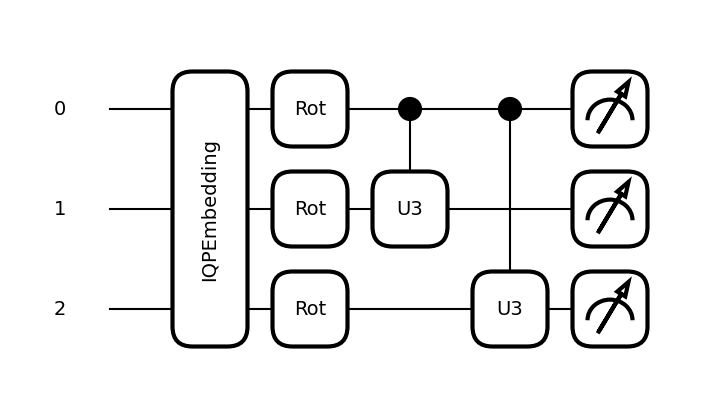

In [22]:
params = np.arange(1000)
input = torch.tensor(np.arange(3))
qml.draw_mpl(quanv_circ3)(input, params)